# Requirements

In [2]:
!pip install together langchain langgraph langchain_openai ipywidgets==7.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 990.3/990.3 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.9/378.9 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.8/275.8 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.0/337.0 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.

# Import

In [30]:
import os
import re
from together import Together
from langchain.chains import LLMChain
from langchain_openai import ChatOpenAI
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from typing import Dict, TypedDict, Optional, Annotated, Literal, List, Tuple
from langgraph.graph import END, StateGraph, MessagesState
from langgraph.checkpoint import MemorySaver
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display, clear_output
import ipywidgets as widgets

# API keys

In [31]:
os.environ["OPENAI_API_KEY"] = "YOUR_OPENAI_API_KEY"
os.environ['TOGETHER_API_KEY'] = "YOUR_TOGETHER_API_KEY"

# Graph Nodes

In [32]:
def play(state):

    question = state.get('question', '').strip()
    x_positions = state.get('x_positions')
    o_positions = state.get('o_positions')
    board = state.get('board', '').strip()

    code_prompt = ChatPromptTemplate.from_messages(
    [("system", """
    You are an expert Tic-tac-toe player. The game is played on a 3x3 grid. You are the second player (O), and your opponent is X.

    CRITICAL: Follow this algorithm EXACTLY:

    1. Analyze the board state:
      - Create a 3x3 grid representation of the board based on the given moves.
      - Mark 'X' for opponent's moves, 'O' for your moves, and '.' for empty cells.

    2. Check for immediate threats:
      - Look for any row, column, or diagonal with TWO 'X' and ONE empty cell.
      - If found, you MUST place your 'O' in that empty cell. Return this move immediately.

    3. If no immediate threat:
      - Choose the center (2,2) if it's empty.
      - If center is taken, choose a corner (1,1), (1,3), (3,1), or (3,3) if available.
      - If no corners are available, choose any empty side (1,2), (2,1), (2,3), or (3,2).

    Your response MUST be in the format: "response: row,column"
    Rows are numbered 1 (top) to 3 (bottom). Columns are numbered 1 (left) to 3 (right).

    Example:
    Given board:
    .|X|.
    .|X|.
    O|.|.

    Correct response: "response: 3,2" (blocking the vertical threat)

    Analyze the provided game state carefully and follow the algorithm step by step.
        """),
        ("human", "{question}")
    ])


    player_chain = LLMChain(llm=model_together, prompt=code_prompt)

    initial_move = player_chain.run(question=question)

    print("Initial move:", initial_move)
    r, c = map(int, re.findall(r'\d+', initial_move))

    return {"response": initial_move, "cell_number": ((r-1)*3)+(c-1)}


In [39]:
def judge(state):

    question = state.get('question', '').strip()
    x_positions = state.get('x_positions')
    initial_move = state.get('response', '').strip()
    count = state.get('count')
    x_positions = state.get('x_positions')
    o_positions = state.get('o_positions')
    board = state.get('board', '').strip()

    judge_prompt = ChatPromptTemplate.from_messages([
    ("system", """
    You are an impartial Tic-tac-toe judge. Your task is to evaluate a move made by player O (second player) and determine if it's the best possible move.

    CRITICAL: Follow these steps to evaluate the move:

    1. Analyze the current board state.
    2. Check if the proposed move by player O is legal (in an empty cell).
    3. Determine if there was an immediate threat (two Xs in a line) that O should have blocked.
    4. If there was no immediate threat, evaluate if the move was strategic (center, corner, or side in that order of preference).

    Respond with one of the following:
    - "CORRECT" if the move was the best possible move.
    - "INCORRECT" if there was a better move available, especially if it failed to block an immediate threat.

    Also, provide a brief explanation of your judgment.
        """),
        ("human", "{question}")
    ])

    judge_chain = LLMChain(llm=model_together, prompt=judge_prompt)

    def judge_move(question, proposed_move):
        judge_question = f"""
        Current game state:
        {question}

        Proposed move by player O:
        {proposed_move}

        Is this the best move? Just say CORRECT or INCORRECT.
        if this move dont prevent from winning the X in next step, so this is INCORRECT.
        """

        judge_result = judge_chain.run(question=judge_question)
        return judge_result



    judgment = judge_move(question, initial_move)

    if "INCORRECT" in judgment.upper() and count <= 1:
        print("INCORRECT")
        judge_result = "INCORRECT"
        question = f"""
        Proposed move is INCORRECT. Please analyze the board carefully and make a new move. Avoid to response the proposed move.
        Current game state:
        {question}

        Proposed move by player O:
        {initial_move}

        """
        count += 1
        next = "play"

    elif "INCORRECT" in judgment.upper() and count > 1:
        print("INCORRECT-END")
        print("Final move:", initial_move)
        judge_result = "INCORRECT"
        next = END

    else:
        print(judgment.upper())
        print("Final move:", initial_move)
        judge_result = "CORRECT"
        next = END

    return {"next": next, "judge_result": judge_result, "count": count, "question": question}


In [40]:
def decide_next_node(state):
    return state.get("next")

# LangGraph

In [41]:
class GraphState(TypedDict):
    board: Optional[str]
    x_positions: Optional[list]
    o_positions: Optional[list]
    response: Optional[str]
    cell_number: Optional[int]
    next: Optional[str]
    judge_result: Optional[str]
    count: Optional[int]
    question: Optional[str]

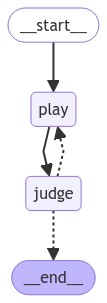

In [42]:
#Graph
workflow = StateGraph(GraphState)

#Nodes
workflow.add_node("play", play)
workflow.add_node("judge", judge)
workflow.set_entry_point("play")

#Edges
workflow.add_edge("play", "judge")
workflow.add_conditional_edges("judge", decide_next_node, {"play":"play", END:END})

#Make Graph
app = workflow.compile()

#Plot Graph
try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    pass

# Play

In [43]:
def index_to_coordinates(index: int) -> Tuple[int, int]:
    return ((index // 3)+1, (index % 3)+1)

def generate_board_str(board):
    if len(board) != 9:
        return "Invalid board size"
    formatted_board = [cell if cell != '' else '.' for cell in board]

    rows = [
        '|'.join(formatted_board[0:3]),
        '|'.join(formatted_board[3:6]),
        '|'.join(formatted_board[6:9])
    ]

    result = '\n'.join(rows)
    return result

def is_winner(board: List[Literal['X', 'Y', '']]) -> bool:
    combinations = [
        (0, 1, 2), (3, 4, 5), (6, 7, 8),  # rows
        (0, 3, 6), (1, 4, 7), (2, 5, 8),  # columns
        (0, 4, 8), (2, 4, 6)  # diagonals
    ]
    for combo in combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] != '':
            return True
    return False

def button_click(b: widgets.Button):
    global current_player, game_over

    if game_over or b.description != '':
        return

    b.description = current_player
    idx = int(b.tooltip)
    board[idx] = current_player

    if is_winner(board):
        output.clear_output()
        with output:
            show_message(f"{'Human' if current_player == 'X' else 'AI'} wins!")
        game_over = True
    elif '' not in board:
        output.clear_output()
        with output:
            show_message("It's a draw!")
        game_over = True
    else:
        current_player = 'O' if current_player == 'X' else 'X'
        if current_player == 'O': # llm
            x_positions = [index_to_coordinates(i) for i, val in enumerate(board) if val == 'X']
            o_positions = [index_to_coordinates(i) for i, val in enumerate(board) if val == 'O']
            question = f"""
            **The moves by the first player (marked by X): {x_positions}. The moves by the second player (marked by O): {o_positions}. \
            You are a master at the Tic-tac-toe game, and you are unbeatable. You are the second player. What would be your next move \
            to prevent the first player from winning? Do not explain your move. Just give it in the format 'response: row number, column \
            number' for an available position. The board looks like this:**

            ```
            {generate_board_str(board)}
            ```

            **The correct move would be:**
            """
            inputs = {"question":question, 'x_positions':x_positions, "o_positions":o_positions,
                      "board":generate_board_str(board), "count":0}
            result = app.invoke(inputs)
            next_idx = result['cell_number']
            button_click(buttons[next_idx])

def show_message(text: str):
    text_label = widgets.Label(
        value=text.upper(),
        layout=widgets.Layout(
            font_size='20px',
            color='white',
            text_align='center'
        )
    )

    rectangle_widget = widgets.Box(
        children=[text_label],
        layout=widgets.Layout(
            width='340px',
            height='50px',
            border='1px solid gray',
            display='flex',
            align_items='center',
            justify_content='center',
            background_color='gray'
        )
    )

    display(rectangle_widget)

def create_horizontal_line() -> widgets.Box:
    return widgets.Box(layout=widgets.Layout(height='1px', width='340px', border='7px solid gray'))

def create_vertical_line() -> widgets.Box:
    return widgets.Box(layout=widgets.Layout(width='1px', height='105px', border='7px solid gray'))

def create_board() -> widgets.VBox:
    global buttons
    buttons = [
        widgets.Button(description='', tooltip=str(i),
                      layout=widgets.Layout(width='100px', height='100px'),
                      style={'font_weight': 'bold', 'font_size': '32px', 'button_color': 'transparent'})
        for i in range(9)
    ]
    for button in buttons:
        button.on_click(button_click)

    return widgets.VBox([
        widgets.HBox([buttons[0], create_vertical_line(), buttons[1], create_vertical_line(), buttons[2]]),
        create_horizontal_line(),
        widgets.HBox([buttons[3], create_vertical_line(), buttons[4], create_vertical_line(), buttons[5]]),
        create_horizontal_line(),
        widgets.HBox([buttons[6], create_vertical_line(), buttons[7], create_vertical_line(), buttons[8]])
    ])

## GPT-4o

In [44]:
model_together = ChatOpenAI(
    model_name='gpt-4o',
    openai_api_key = os.environ["OPENAI_API_KEY"],
    temperature=0
    )

board = ['' for _ in range(9)]
current_player: Literal['X', 'Y'] = 'X'
game_over = False
buttons: List[widgets.Button] = []

output = widgets.Output()
display(create_board(), output)

Output()

Initial move: response: 2,2
CORRECT

EXPLANATION: THERE IS NO IMMEDIATE THREAT FROM PLAYER X THAT NEEDS TO BE BLOCKED. THE CENTER POSITION (2,2) IS THE MOST STRATEGIC MOVE FOR PLAYER O.
Final move: response: 2,2
Initial move: response: 2,1
INCORRECT
Initial move: response: 1,2
INCORRECT
Initial move: response: 1,3
INCORRECT-END
Final move: response: 1,3


## Llama3.1

In [45]:
board = ['' for _ in range(9)]
current_player: Literal['X', 'Y'] = 'X'
game_over = False
buttons: List[widgets.Button] = []

model_together = ChatOpenAI(
    base_url="https://api.together.xyz/v1",
    model="meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",
    #model = "mistralai/Mixtral-8x22B-Instruct-v0.1",
    #model="mistralai/Mistral-7B-Instruct-v0.3",
    #model="google/gemma-2-27b-it"
    api_key=os.environ["TOGETHER_API_KEY"],
    temperature=0
    )

output = widgets.Output()
display(create_board(), output)

Output()

Initial move: response: 2,2
CORRECT
Final move: response: 2,2
Initial move: response: 2,1
CORRECT
Final move: response: 2,1
Initial move: response: 3,3
CORRECT
Final move: response: 3,3
